In [1]:
# pip install pyspark
# ! pip uninstall openpyxl


### Quick Spark Project

In [33]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


Build a spark session and set a name for the application. Then cache data in off-heap memory to avoid storing it directly on disk, and the amount of memory is manually specified

In [2]:
# Create Spark session

# spark = SparkSession.builder.appName("Pyspark demo").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

spark = SparkSession.builder.appName("Pyspark demo").getOrCreate()

24/10/08 14:05:29 WARN Utils: Your hostname, mjmac.local resolves to a loopback address: 127.0.0.1; using 192.168.1.38 instead (on interface en0)
24/10/08 14:05:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/08 14:05:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read file
df = pd.read_excel('/Users/mercycherono/Documents/GitHub/spark/Online Retail.xlsx', header=0)

In [4]:
# Convert to Spark DataFrame
df = spark.createDataFrame(df)

In [6]:
df.head(5)

24/10/08 14:10:57 WARN TaskSetManager: Stage 0 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:11:06 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker


[Row(InvoiceNo='536365', StockCode='85123A', Description='WHITE HANGING HEART T-LIGHT HOLDER', Quantity=6, InvoiceDate=datetime.datetime(2010, 12, 1, 8, 26), UnitPrice=2.55, CustomerID=17850.0, Country='United Kingdom'),
 Row(InvoiceNo='536365', StockCode='71053', Description='WHITE METAL LANTERN', Quantity=6, InvoiceDate=datetime.datetime(2010, 12, 1, 8, 26), UnitPrice=3.39, CustomerID=17850.0, Country='United Kingdom'),
 Row(InvoiceNo='536365', StockCode='84406B', Description='CREAM CUPID HEARTS COAT HANGER', Quantity=8, InvoiceDate=datetime.datetime(2010, 12, 1, 8, 26), UnitPrice=2.75, CustomerID=17850.0, Country='United Kingdom'),
 Row(InvoiceNo='536365', StockCode='84029G', Description='KNITTED UNION FLAG HOT WATER BOTTLE', Quantity=6, InvoiceDate=datetime.datetime(2010, 12, 1, 8, 26), UnitPrice=3.39, CustomerID=17850.0, Country='United Kingdom'),
 Row(InvoiceNo='536365', StockCode='84029E', Description='RED WOOLLY HOTTIE WHITE HEART.', Quantity=6, InvoiceDate=datetime.datetime(20

#### Quick EDA

In [7]:
df.show(5,0)

24/10/08 14:11:19 WARN TaskSetManager: Stage 1 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:11:23 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1 (TID 1): Attempting to kill Python Worker


+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850.0   |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850.0   |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
+---------+-----

*Variables*

InvoiceNo: The unique identifier of each customer invoice.

StockCode: The unique identifier of each item in stock.

Description: The item purchased by the customer.

Quantity: The number of each item purchased by a customer in a single invoice.

InvoiceDate: The purchase date.

UnitPrice: Price of one unit of each item.

CustomerID: Unique identifier assigned to each user.

Country: The country from where the purchase was made

In [8]:
#data size
df.count()  

24/10/08 14:14:01 WARN TaskSetManager: Stage 2 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.


541909

In [10]:
#unique 
df.select('CustomerID').distinct().count() 

24/10/08 14:14:31 WARN TaskSetManager: Stage 5 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.


4373

In [11]:
#country with most purchases
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).show()

24/10/08 14:15:09 WARN TaskSetManager: Stage 11 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.


+------------------+-------------+
|           Country|country_count|
+------------------+-------------+
|            Sweden|            8|
|         Singapore|            1|
|           Germany|           95|
|               RSA|            1|
|            France|           88|
|            Greece|            4|
|European Community|            1|
|           Belgium|           25|
|           Finland|           12|
|             Malta|            2|
|       Unspecified|            5|
|             Italy|           15|
|              EIRE|            4|
|         Lithuania|            1|
|            Norway|           10|
|             Spain|           31|
|           Denmark|            9|
|         Hong Kong|            1|
|           Iceland|            1|
|            Israel|            5|
+------------------+-------------+
only showing top 20 rows



In [12]:
#Sort purchases
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

24/10/08 14:15:54 WARN TaskSetManager: Stage 17 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.


+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3951|
|        Germany|           95|
|         France|           88|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           22|
|       Portugal|           20|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|    Unspecified|            5|
+---------------+-------------+
only showing top 20 rows



In [14]:
#latest purchase
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))
df.select(max("date")).show()

24/10/08 14:16:31 WARN TaskSetManager: Stage 23 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



In [15]:
df.select(min("date")).show()

24/10/08 14:17:17 WARN TaskSetManager: Stage 26 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



#### Quick Data Pre-processing

From our data we will to create multiple customer segments based on each user’s purchase behavior. 

The variables in this dataset are in a format that cannot be easily ingested into the customer segmentation model. These features individually do not tell us much about customer purchase behavior.

Due to this, we will use the existing variables to derive three new informative features - recency, frequency, and monetary value (RFM).

RFM is commonly used in marketing to evaluate a client’s value based on their:

*Recency*: How recently has each customer made a purchase?
*Frequency*: How often have they bought something?
*Monetary Value*: How much money do they spend on average when making purchases?
We will now preprocess the dataframe to create the above variables.

*Recency*
First, let’s calculate the value of recency - the latest date and time a purchase was made on the platform. This can be achieved in two steps:

i) Assign a recency score to each customer
*We will subtract every date in the dataframe from the earliest date. This will tell us how recently a customer was seen in the dataframe. A value of 0 indicates the lowest recency, as it will be assigned to the person who was seen making a purchase on the earliest date.

In [16]:
df = df.withColumn("from_date", lit("12/1/10 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

ii) Select the most recent purchase

In [17]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [18]:
#let's check on recency
df2.show(5,0)

24/10/08 14:21:56 WARN TaskSetManager: Stage 29 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:22:06 WARN TaskSetManager: Stage 30 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.


+---------+---------+---------+------------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+
|recency  |InvoiceNo|StockCode|Description             |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |date               |from_date          |
+---------+---------+---------+------------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+
|-27704940|544815   |22421    |LIPSTICK PEN FUSCHIA    |12      |2011-02-23 16:37:00|0.42     |17171.0   |United Kingdom|2011-02-23 16:37:00|2012-01-10 08:26:00|
|-27704940|544815   |22419    |LIPSTICK PEN RED        |12      |2011-02-23 16:37:00|0.42     |17171.0   |United Kingdom|2011-02-23 16:37:00|2012-01-10 08:26:00|
|-27704940|544815   |22420    |LIPSTICK PEN BABY PINK  |12      |2011-02-23 16:37:00|0.42     |17171.0   |United Kingdom|2011-02-23 16:37:00|2012-01-10 08:26:00|
|-27704940|544815   |22077  

In [20]:
#view all variables now
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



Frequency

In [21]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [22]:
df_freq.show(5,0)

24/10/08 14:23:14 WARN TaskSetManager: Stage 35 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:23:21 WARN TaskSetManager: Stage 36 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.


+----------+---------+
|CustomerID|frequency|
+----------+---------+
|18114.0   |28       |
|13973.0   |11       |
|13533.0   |33       |
|12493.0   |11       |
|14024.0   |3        |
+----------+---------+
only showing top 5 rows



In [23]:
#add it to the main df
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [24]:
df3.printSchema()

root
 |-- CustomerID: double (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



Monetary Value

the total amount spent by each customer. 

 i) Find the total amount spent in each purchase:

Each customerID comes with variables called Quantity and UnitPrice for a single purchase:

 Quantity * UnitPrice

In [25]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

ii) Find the total amount spent by each customer:

In [26]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [27]:
#add it to the other df
finaldf = m_val.join(df3,on='CustomerID',how='inner')

In [28]:
#columns that we use for the model only
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

Standardization - to scale the variables

In [29]:
assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

24/10/08 14:27:38 WARN TaskSetManager: Stage 44 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:28:02 WARN TaskSetManager: Stage 45 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:28:09 WARN TaskSetManager: Stage 46 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:28:15 WARN TaskSetManager: Stage 47 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.


In [31]:
#check on standardized features
data_scale_output.select('standardized').show(2,truncate=False)

24/10/08 14:32:12 WARN TaskSetManager: Stage 83 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:32:23 WARN TaskSetManager: Stage 84 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:32:34 WARN TaskSetManager: Stage 85 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:32:41 WARN TaskSetManager: Stage 86 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.


+--------------------------------------------------------------+
|standardized                                                  |
+--------------------------------------------------------------+
|[-2.026892415433531,0.02078788124665093,0.0399651638373568]   |
|[-0.42344813175146395,0.13858587497767286,0.09925473358128228]|
+--------------------------------------------------------------+
only showing top 2 rows



#### Build the Model!!!

i) Finding the number of clusters to use using K Means

When building a K-Means clustering model, we need to determine the number of clusters or groups we want the algorithm to return. If we pick 3 we get 3 customer segments.

 “elbow-method” is popularly used to decide on how many clusters to use in K-Means 

This is done simply running the K-Means algorithm for a wide range of clusters and visualizing the model results for each cluster. The plot will have an inflection point that looks like an elbow, and we just pick the number of clusters from this point


let's try using 2 to 6 clusters

In [32]:
max_k = 6

cost = np.zeros(max_k)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2, max_k):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

24/10/08 14:36:24 WARN TaskSetManager: Stage 116 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:36:33 WARN TaskSetManager: Stage 117 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:36:38 WARN TaskSetManager: Stage 118 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:36:48 WARN TaskSetManager: Stage 119 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:37:01 WARN TaskSetManager: Stage 143 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:37:07 WARN TaskSetManager: Stage 144 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:37:11 WARN TaskSetManager: Stage 145 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.

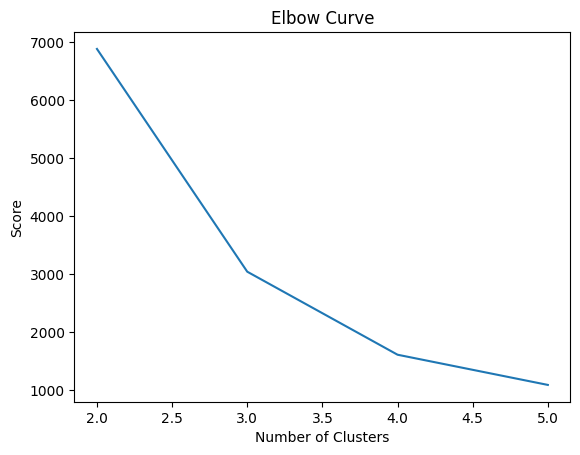

In [34]:
# visulaise it
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2, max_k)
df_cost.insert(0, 'cluster', new_col)
plt.plot(df_cost.cluster, df_cost.cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

ii) Building the K-Means Clustering Model

In [35]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

24/10/08 14:43:43 WARN TaskSetManager: Stage 861 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:43:53 WARN TaskSetManager: Stage 862 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:43:57 WARN TaskSetManager: Stage 863 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:44:00 WARN TaskSetManager: Stage 864 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:44:09 WARN TaskSetManager: Stage 900 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:44:13 WARN TaskSetManager: Stage 901 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:44:15 WARN TaskSetManager: Stage 902 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.

iii) predict

In [36]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

24/10/08 14:44:39 WARN TaskSetManager: Stage 1022 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:44:42 WARN TaskSetManager: Stage 1023 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:44:45 WARN TaskSetManager: Stage 1024 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:44:52 WARN TaskSetManager: Stage 1025 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.


+---------+---------+------------------+----------+-----------------------------------+------------------------------------------------------------------+----------+
|recency  |frequency|monetary_value    |CustomerID|features                           |standardized                                                      |prediction|
+---------+---------+------------------+----------+-----------------------------------+------------------------------------------------------------------+----------+
|-17700600|6        |178.51999999999998|17879.0   |[-1.77006E7,6.0,178.51999999999998]|[-2.026892415433531,0.02078788124665093,0.0399651638373568]       |3         |
|-3697920 |40       |443.36            |16347.0   |[-3697920.0,40.0,443.36]           |[-0.42344813175146395,0.13858587497767286,0.09925473358128228]    |0         |
|-5518440 |33       |527.05            |17623.0   |[-5518440.0,33.0,527.05]           |[-0.631915538514232,0.11433334685658011,0.11799036298722217]      |0         |
|-21

#### Cluster Analysis

24/10/08 14:45:16 WARN TaskSetManager: Stage 1054 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:45:24 WARN TaskSetManager: Stage 1055 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:45:32 WARN TaskSetManager: Stage 1056 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.
24/10/08 14:45:38 WARN TaskSetManager: Stage 1057 contains a task of very large size (8486 KiB). The maximum recommended task size is 1000 KiB.


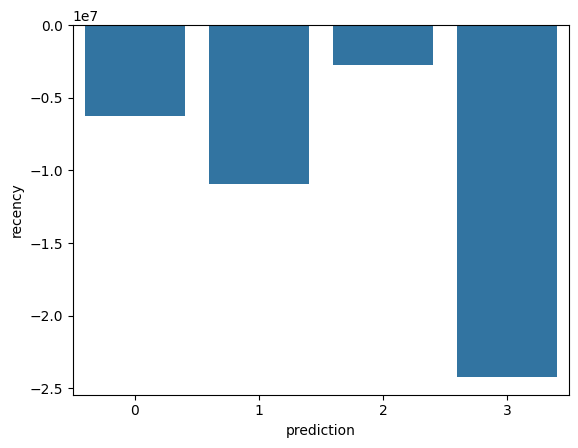

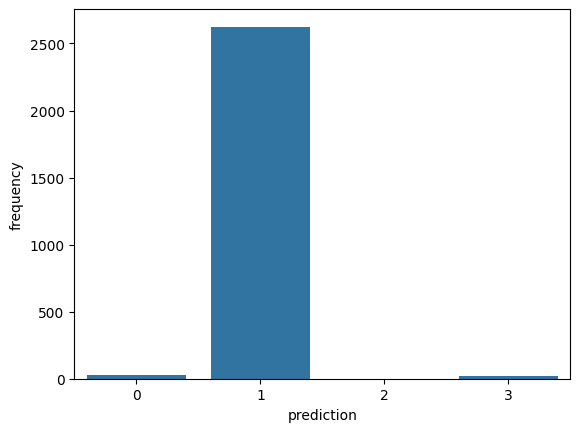

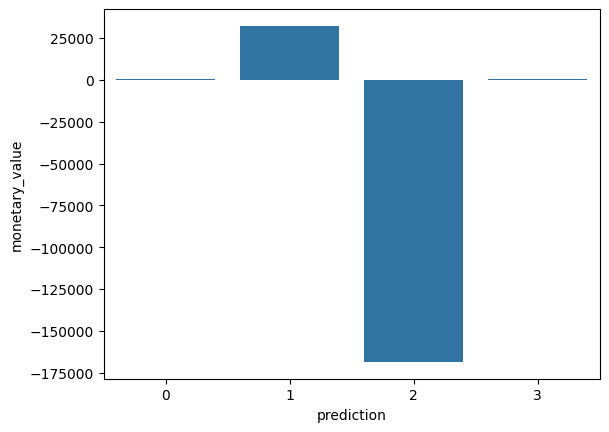

In [37]:
df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

Final Assumptions

Cluster 0: low recency, frequency, and monetary value
 

Cluster 1: high recency but haven’t been seen spending much on the platform

Cluster 2: medium recency and frequency and spend a lot of money on the platform
 

Cluster 3:  high recency and make frequent purchases on the platform. However, they don’t spend much on the platform which means that they tend to select cheaper items in each purchase